# INTRODUCTION

## Overview
In this project, we will be analysing the Kings county housing dataset
Our objective is to use linear regression techniques to develop a model which can be used to predict the price of a home not already described in our original data set, based on the input of other data related to the house. 


# OBTAIN

## Importing libraries and dataset
First off, lets import the modules we will require for this analysis, as well as the dataset itself. 
After that, let's take a quick look at the head of our primary dataframe to get a glimpse of our data. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer

# Lets set some universal options

pd.set_option('precision', 4)
mpl.rcParams['figure.figsize'] = (20,20)

# The raw dataset will be stored as 'df0'. We will make copies of this dataframe as needed and try to keep this 
    # dataframe unchanged so we always have an original, unchanged version of the dataset available. 
    
df0 = pd.read_csv('kc_house_data.csv')

#We will use 'df1' as our work-horse dataframe. This will be the active dataframe we take through each phase,
    #and which we will trim and transform to produce the final clean dataset we will feed into out model. 
    
df1 = df0.copy()

# Lets examine out dataframe:
display(df1.head())
display(df1.info())

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


None

## Preliminary Overview
We will now gather some information about our data set. The function below takes the dataset and returns a dataframe
with the following information for each column:
    1. The data type of the columns
    2. The missing values in the column, expressed as a percentage of the total records. 
    3. The number of unique values in the column

In [2]:
def report1 (dataframe):
    
    master={}

    for column in dataframe.columns:
        master[column]={}
        col_dict = master[column]
        col_dict['type'] = str(dataframe[column].dtypes)
        col_dict['% empty'] = round(((len(dataframe)-dataframe[column].count())/len(dataframe))*100,2)
        col_dict['unique values'] = dataframe[column].nunique()
        col_dict['min'] = dataframe[column].min()
        col_dict['max'] = dataframe[column].max()
        
    df_report=pd.DataFrame.from_dict(master,orient='index')
    df_report.sort_values(['unique values'],ascending=False,inplace=True)
        
    return df_report

df_report = report1(df1)

display(report1(df1))




,type,% empty,unique values,min,max
id,int64,0.00,21420,1000102,9900000190
sqft_lot,int64,0.00,9776,520,1651359
sqft_lot15,int64,0.00,8682,651,871200
lat,float64,0.00,5033,47.16,47.78
price,float64,0.00,3622,7.8e+04,7.7e+06
sqft_living,int64,0.00,1034,370,13540
sqft_above,int64,0.00,942,370,9410
sqft_living15,int64,0.00,777,399,6210
long,float64,0.00,751,-122.5,-121.3
date,object,0.00,372,1/10/2015,9/9/2014


# SCRUB

## Recasting Data Types
We now take a closer look at which columns have a datatype of 'object', and whether we may turn them into numbers. 

In [3]:
df_objects = list(df_report[df_report['type'] == 'object'].index)
display(df_objects)


['date', 'sqft_basement']

Lets turn these into more appropriate data types.

In [4]:
df1['date'] = pd.to_datetime(df1['date'])
#df1['sqft_basement'] = pd.to_numeric(df1['sqft_basement'])


I commented out the line to recast sqft_basement. Turns out it has some problematic values in it. Lets hold off for now, we may end up dropping this column later for other reasons. 

As for the 'date' column, on second thought, lets drop it. We need to convert all our data into numeric form. We could conceivably do this with the date column but it would require some engineering. But if we think about it, the date column is probably not very useful to us in this case. IT describes the date that the house in question was sold. I dont really see how this can have any significant effect on the price of a house. Lets at least drop it for now and perhaps we can retrain our model with a modified version of it later to see if it makes any difference. 

In [5]:
df1 = df1.sort_values('date',ascending=True)
df1 = df1.drop(['date'],axis=1)

## Duplicate Records

We would like to assume that each row in the dataset refers to just one house. The 'id' column is described as being the unique identifier for a houe. However, even though the dataset is 21597 records long, 'id' has 21420 unique values, and no missing values. This might indicate the existence of duplicates. 

In [6]:
df_id_Counts = df1['id'].value_counts()
repeats = df_id_Counts[df_id_Counts > 1]
repeats = list(repeats.index)

df_dups = df1[df1['id'].isin(repeats)]
print(df_dups.head())


               id     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
15642  7893805650  210000.0         5        2.0         2050     10200   
20037  8648900110  555000.0         3        2.5         1940      3211   
14987  7504021310  525000.0         3        2.5         2970     11985   
10246  1995200200  313950.0         3        1.0         1510      6083   
10215  8945100320  136500.0         3        1.5         1420      8580   

       floors  waterfront  view  condition  grade  sqft_above sqft_basement  \
15642     1.0         0.0   0.0          3      6        1430         620.0   
20037     2.0         0.0   0.0          3      8        1940           0.0   
14987     1.0         0.0   0.0          3      9        1770        1200.0   
10246     1.0         0.0   0.0          4      6         860         650.0   
10215     1.0         0.0   0.0          3      6        1420           0.0   

       yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \

It seems that the duplicate id's are for when the same houses were sold again. Lets split the duplicates up and take a closer look.


In [7]:

df11 = df1.copy()
df11=df11.loc[:,['bathrooms','bedrooms','zipcode','id','sqft_lot']]


dupe1 = df11.duplicated('id',keep='first')
df_dup1 = df11[dupe1]

dupe2 = df11.duplicated('id',keep='last')
df_dup2 = df11[dupe2]

dupes_merged = df_dup1.merge(df_dup2,left_on='id',right_on='id',how='outer')
display(dupes_merged)




,bathrooms_x,bedrooms_x,zipcode_x,id,sqft_lot_x,bathrooms_y,bedrooms_y,zipcode_y,sqft_lot_y
0,2.50,4,98077,7701960990,14565,2.50,4,98077,14565
1,2.50,3,98027,8648900110,3211,2.50,3,98027,3211
2,3.50,4,98006,4139420590,16643,3.50,4,98006,16643
3,2.25,3,98007,4305200070,7200,2.25,3,98007,7200
4,1.50,3,98023,8945100320,8580,1.50,3,98023,8580
...,...,...,...,...,...,...,...,...,...
174,1.00,2,98065,5417600130,9000,1.00,2,98065,9000
175,2.00,3,98004,5536100020,15788,2.00,3,98004,15788
176,1.50,2,98103,9136103130,4013,1.50,2,98103,4013
177,1.75,2,98053,8682262400,4003,1.75,2,98053,4003


As we can see, the duplicate ids refer to the same houses as they refer to houses with the same number of bedrooms, bathrooms, square footage etc. Given that there are only 176 duplicate house, i.e. aounr 0.78% of the rows of the dataset, we can safely discard them. Once we have done that, lets set the id number as the index of the dataframe. 


In [8]:
df1 = df1.drop_duplicates('id')
df1.set_index('id',inplace=True)
display(report1(df1))
display(df1.head())

,type,% empty,unique values,min,max
sqft_lot,int64,0.00,9776,520,1651359
sqft_lot15,int64,0.00,8682,651,871200
lat,float64,0.00,5033,47.16,47.78
price,float64,0.00,3607,7.8e+04,7.7e+06
sqft_living,int64,0.00,1034,370,13540
sqft_above,int64,0.00,942,370,9410
sqft_living15,int64,0.00,777,399,6210
long,float64,0.00,751,-122.5,-121.3
sqft_basement,object,0.00,304,0.0,?
yr_built,int64,0.00,116,1900,2015


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,
2202500290,435000.0,4,1.0,1450,8800,1.0,0.0,0.0,4,7,1450,0.0,1954,0.0,98006,47.5746,-122.135,1260,8942
7853361370,555000.0,4,2.5,3310,6500,2.0,0.0,0.0,3,8,3310,0.0,2012,0.0,98065,47.5150,-121.870,2380,5000
7197300105,550000.0,4,2.5,1940,10500,1.0,NaN,0.0,4,7,1140,800.0,1976,0.0,98052,47.6830,-122.114,2200,10500
3438501320,295000.0,2,2.5,1630,1368,2.0,0.0,0.0,3,7,1280,350.0,2009,0.0,98106,47.5489,-122.363,1590,2306
472000620,790000.0,3,2.5,2600,4750,1.0,0.0,0.0,4,9,1700,900.0,1951,0.0,98117,47.6833,-122.400,2380,4750


## Placeholders.

Finding missing values is simple enough: we can use native python methods to examine the null values in a given dataframe or series. But as we know, oftentimes datasets have palceholder values that are actually null values, although not encoded as such. Finding these is trickier. One way is to look at the counts of unique values in each dataframe column to see if anything jumps out.

The function below iterates over all the columns in a dataframe. It find the unique values in that column, along with their counts. It then returns a dataframe showing the top (n) most common values in each column. This data frame allows us to quickly see whether any column seems to have any unusually large proportions of a certain value. If we see unusually high counts of the same value in a column, we can explore further to see if that value is a placeholder of some kind. 

In [9]:

def value_counts_numeric(dataframe,n_highest_counts):
    rows_list={}
    for col in dataframe.columns:
        series1 = dataframe[col].value_counts().head(n_highest_counts)
        series2 = round((series1/len(dataframe)) * 100, 2)        
        rowlist = list(series2)        
        rows_list[col] = rowlist
    
    counts_df = pd.DataFrame.from_dict(rows_list,orient='index',columns=[x for x in range(1,n_highest_counts+1)])
    counts_df.sort_values(by=1,inplace=True,ascending=False)
    
    return counts_df


display(value_counts_numeric(df1,10))        

,1,2,3,4,5,6,7,8,9,10
view,89.88,4.46,2.36,1.54,1.47,NaN,NaN,NaN,NaN,NaN
waterfront,88.33,0.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yr_renovated,78.79,0.34,0.14,0.14,0.14,0.14,0.14,0.10,0.10,0.10
condition,64.89,26.34,7.88,0.76,0.13,NaN,NaN,NaN,NaN,NaN
sqft_basement,59.37,2.11,1.01,0.96,0.96,0.94,0.86,0.68,0.66,0.66
floors,49.26,38.30,8.81,2.84,0.75,0.03,NaN,NaN,NaN,NaN
bedrooms,45.43,31.97,12.77,7.40,1.24,0.89,0.18,0.06,0.03,0.01
grade,41.50,28.20,12.17,9.31,5.28,1.85,1.09,0.41,0.13,0.06
bathrooms,24.99,17.71,14.10,9.48,8.93,6.67,5.52,3.49,3.40,2.74
zipcode,2.80,2.74,2.69,2.67,2.56,2.55,2.54,2.32,2.30,2.29


We can see that some columns are dominated by one value, or a handful of values. It would behoove us to know exactly which values constitute such large portions of the column. To that end, the function below returns a more descriptive dataframe, in which each cell represents the value and its associated percentage in the column. We can pass into this function a list of columns, so we only return details on columns of interest. We will slice the dataframe returned in the previous cell to get details on columns that have very high rates of duplicate values. 

In [10]:
def value_counts_desc(dataframe,columns,n_highest_counts):
    rows_list={}
    for col in columns:
        series1 = dataframe[col].value_counts().head(n_highest_counts)
        series2 = round((series1/len(dataframe)) * 100, 0)        
        series2 = series2.astype('str')
        series2 = series2.index.astype('str') + '['+ series2 + '%'+']'
        rowlist = list(series2)        
        rows_list[col] = rowlist
    
    counts_df = pd.DataFrame.from_dict(rows_list,orient='index',columns=[x for x in range(1,n_highest_counts+1)])
    
    return counts_df

df_value_counts = value_counts_numeric(df1,20)
highest_counts = df_value_counts[df_value_counts[1] > 25]
high_count_columns=list(highest_counts.index)

display(value_counts_desc(df1,high_count_columns,10))


,1,2,3,4,5,6,7,8,9,10
view,0.0[90.0%],2.0[4.0%],3.0[2.0%],1.0[2.0%],4.0[1.0%],None,None,None,None,None
waterfront,0.0[88.0%],1.0[1.0%],None,None,None,None,None,None,None,None
yr_renovated,0.0[79.0%],2014.0[0.0%],2003.0[0.0%],2013.0[0.0%],2007.0[0.0%],2000.0[0.0%],2005.0[0.0%],2004.0[0.0%],1990.0[0.0%],2009.0[0.0%]
condition,3[65.0%],4[26.0%],5[8.0%],2[1.0%],1[0.0%],None,None,None,None,None
sqft_basement,0.0[59.0%],?[2.0%],600.0[1.0%],500.0[1.0%],700.0[1.0%],800.0[1.0%],400.0[1.0%],1000.0[1.0%],300.0[1.0%],900.0[1.0%]
floors,1.0[49.0%],2.0[38.0%],1.5[9.0%],3.0[3.0%],2.5[1.0%],3.5[0.0%],None,None,None,None
bedrooms,3[45.0%],4[32.0%],2[13.0%],5[7.0%],6[1.0%],1[1.0%],7[0.0%],8[0.0%],9[0.0%],10[0.0%]
grade,7[41.0%],8[28.0%],9[12.0%],6[9.0%],10[5.0%],11[2.0%],5[1.0%],12[0.0%],4[0.0%],13[0.0%]


### Analysis
From the preceeding, we can make the following observations:

1. "View" is a binary categorical variable, indicating whether a house has been viewed or not. 90% of the 'view' column has a value of '0', meaning 90% of the houses have not been viewed. This makes is highly likely that this column is not really providing us any useful information. We should probably drop it. 

2. Similary, 88% of 'waterfront' is also '0'. It seems most likely that waterfront is a binary categorical variable, i.e. a house either is not on the waterfront (in which case ot gets a 'o' value), or it is (in which case it gets '1'). Perhaps being on the waterfront makes a house more valuable, and if we build a model that takes into account whether a house is on the waterfront it may be more accurate. However, 11% of the data is missing anyways. For the time being, lets take waterfront out. Perhaps we can retrain our model with it and and see if we notice any performance improvement. 

3. year renovated definitely seems like it should be deleted. 80% of the values are '0', which cannot be explained by the nature of the information in this column ('0' is not a year). And as we saw before, 17% of the values are missing. 

4. condition again seems to be a categorical variable. the values range from 1 to 5, and its probably a way of saying "on a scale of 1 to 5 what is the condition of the property". The most frequent value is 3, occuring 65% of the time, then 4 at 26% of the time. It tapers of before and after. If I had to guess, these values are normally distributed. 3 is right down the middle of the scale, and it makes sense that most houses would be in average condition, and more extreme conditions are less and less likely. We can double check this with a histogram. But we definitely want to retain condition in our feature set. 

5. sqft_basement should definitely go. Around 60% of the values are '0'. 2% are '?'. The remainign values are in increments of 100, which is highly unlikely for a quantity that one would expect to be more continuos and varying (compare with other square foot based columns). 

6. Around 50% of houses have only 1 floor. 40% have 2 floors. It goes down from there. This makes sense. Lets leave this feature in place. 

7. A large portion of houses(45%) have three bedrooms. 32% have 4 bedrooms. The rest have lesser or more. This also in line with what we would expect. 3 seems like the numebr of bedrooms we would expect most houses to have, so this is not unusual. Lets keep this feature

8. 7 is the most common value for grade at 42%. Given that grade ranges from 3 to 13 and 7 is kind of in the middle, this also makes sense. Again, one would expect most houses to be graded average. 

9. Bathrooms also does not seem to have any glaring outliers, and seems in line with our expectations for the most common number of bathrooms across homes. 

Thus far, our list of features to remove looks like this:  

        ['view','waterfront','yr_renovated','sqft_basement']

Lets drop these columns and return a new dataframe. 

In [11]:
high_null_columns = ['view','waterfront','yr_renovated','sqft_basement']

df1=df1.drop(high_null_columns,axis=1)
display(df1.head())
print(df1.info())

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,
2202500290,435000.0,4,1.0,1450,8800,1.0,4,7,1450,1954,98006,47.5746,-122.135,1260,8942
7853361370,555000.0,4,2.5,3310,6500,2.0,3,8,3310,2012,98065,47.5150,-121.870,2380,5000
7197300105,550000.0,4,2.5,1940,10500,1.0,4,7,1140,1976,98052,47.6830,-122.114,2200,10500
3438501320,295000.0,2,2.5,1630,1368,2.0,3,7,1280,2009,98106,47.5489,-122.363,1590,2306
472000620,790000.0,3,2.5,2600,4750,1.0,4,9,1700,1951,98117,47.6833,-122.400,2380,4750


<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 2202500290 to 9106000005
Data columns (total 15 columns):
price            21420 non-null float64
bedrooms         21420 non-null int64
bathrooms        21420 non-null float64
sqft_living      21420 non-null int64
sqft_lot         21420 non-null int64
floors           21420 non-null float64
condition        21420 non-null int64
grade            21420 non-null int64
sqft_above       21420 non-null int64
yr_built         21420 non-null int64
zipcode          21420 non-null int64
lat              21420 non-null float64
long             21420 non-null float64
sqft_living15    21420 non-null int64
sqft_lot15       21420 non-null int64
dtypes: float64(5), int64(10)
memory usage: 2.6 MB
None


## Colinearity

Lets check colinearity across all columns, to help us remove redundant features. 
A heatmap of correlation values will helpful to visually assess correlation among the features. 

The function below generates a clean, non-redundant heatmap of correlation values for the columns of our dataframe. 

(<Figure size 864x864 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f80706d6a10>)

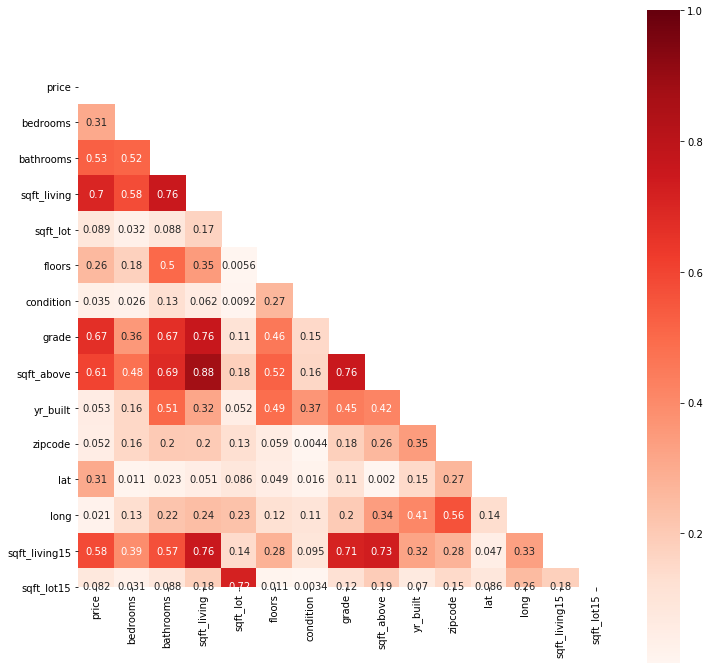

In [12]:
def multiplot(corr,figsize=(12,12)):
    fig, ax = plt.subplots(figsize=figsize)

    mask = np.zeros_like(corr, dtype=np.bool)
    idx = np.triu_indices_from(mask)
    mask[idx] = True

    sns.heatmap(np.abs(corr),square=True,mask=mask,annot=True,cmap="Reds",ax=ax)
    return fig, ax

multiplot(np.abs(df1.corr()))

It looks like some features a strongly co-related, and hence good candidates for removal on account of the multi-colinearity they introduce into the model. 

The function below returns a series consisting of pairs of columns with a Pearson correlation co-efficient higher than 
the specified threshold. The column pairs are displayed as elements of a multilevel index.

We will use this function to return a list of feature pairs with a co-relation value higher than 0.75.

In [13]:
# Function { high_corr } : 
    # Returns a multi-indexed series of the correlations of dataframe columns above specified threshold
    # inputs: 1.  dataframe(Pandas dataframe)   ,  2.  threshold (Only correlations higher than this will be returned)
    
def high_corr(dataframe,threshold):
    corr = dataframe.corr()
    sign_corr = corr[abs(corr) > threshold]
    sign_corr = sign_corr.stack()
    sign_corr.drop_duplicates(inplace=True)
    sign_corr = sign_corr[sign_corr != 1]
    
    
    return sign_corr

display(high_corr(df1,0.75))

bathrooms    sqft_living      0.7555
sqft_living  grade            0.7625
             sqft_above       0.8765
             sqft_living15    0.7562
grade        sqft_above       0.7562
dtype: float64

### Analysis

    Looks like sqft_living correlates with the highest number of other features. While it seems somewhat counter-intuitive to remove a metric as fundamental to evaluating home prices as square footage, on the other hand it seems the other features it co-relates to cover this information. Obviously higher bathrooms means higher square footage. But also, square_above seems to be a more on point data series. We are taking out basement squre footage anyways, and square above reflects this. So we may end up with a cleaner data set if we take out square footage. 

In [14]:
colinear_columns = ['sqft_living']

df1 = df1.drop(colinear_columns,axis=1)

display(report1(df1))

,type,% empty,unique values,min,max
sqft_lot,int64,0.0,9776,520.0000,1.6514e+06
sqft_lot15,int64,0.0,8682,651.0000,8.7120e+05
lat,float64,0.0,5033,47.1559,4.7778e+01
price,float64,0.0,3607,78000.0000,7.7000e+06
sqft_above,int64,0.0,942,370.0000,9.4100e+03
sqft_living15,int64,0.0,777,399.0000,6.2100e+03
long,float64,0.0,751,-122.5190,-1.2131e+02
yr_built,int64,0.0,116,1900.0000,2.0150e+03
zipcode,int64,0.0,70,98001.0000,9.8199e+04
bathrooms,float64,0.0,29,0.5000,8.0000e+00


## Scaling

Now that we have gotten rid of extraneous and potentially disruptive data, let us finalize our dataset by scaling our features. 

# EXPLORE

## Outliers
I want to first remove outliers before scaling data. This seems like the correct approach, because I feel like scaling the data with outliers will produce skewed distributions which I will have to recorrect for outliers anyways, and end up removing the same outlying values I will now. I also want to use min-max scaling as I understand it is better at bringing data into more homogenous scales across columns.

First lets 

In [ ]:

import math

def col_boxplots (dataframe):
    figure, ax = plt.subplots(math.ceil(len(dataframe)/2),2,figsize=(15,30))
    ax = ax.reshape(-1)

    for i,col in enumerate(dataframe.columns):

        dataframe.boxplot(column=col,ax=ax[i])

col_boxplots(df1)


From these boxplots, we can identify some good candidates for culling outliers. 

In [ ]:
def rm_outliers (dataframe, columns, threshold):
    dfa = dataframe
    for col in columns:
        dfa = dfa[dfa[col] <= dfa[col].quantile(threshold)]

columnsa = ['sqft_lot15','price','sqft_lot','sqft_above']

display(rm_outliers(df1,columnsa,.999))
print(df1.info())

## Categorical Variables
We must evaluate our features to see if any of them can rightly be treated as categorical variables, and then undertake the appropriate transformations of our data. 

To identify our categorical variables, lets start by generating a set of scatter plots for each pair of features. 


In [ ]:
pd.plotting.scatter_matrix(df1,figsize=(20,20));

From the scatter plot it seems that the following features might be categorical variables:

In [ ]:
cat_vars =  ['floors','condition','grade','zipcode']

Lets confirm that these variables are expressed as numeric data types. 

In [ ]:
cat_dict = {}
for var in cat_vars:
    
    cat_dict[var] = df1[var].dtype

print(cat_dict)

Zipcode definitely seems like a good candidate for a categorical variable to which we can apply one hot encoding. However, the remaining variables seem...inherently numeric, granted they dont have a large range of values. The number of floors a house has is still a number. Condition and grade are attempts to quantify qualitative features, and as such have already been converted to numeric features for us. 

Perhaps we will encode zipcode using one hot encoding for the time being, but hold off on the remaining candidates for the time being and return to them later. We can train a new model with these values one hot encoded and see if it improves the performance of our model. 


In [ ]:
cat_frame = pd.get_dummies(df1['zipcode'])
cat_frame = cat_frame.astype('int64')

df2_pre_cat = df1.copy()
df1 = df1.merge(cat_frame,left_index=True,right_index=True)


# MODEL

# iNTERPRET

# CONCLUSIONS & RECOMMENDATIONS